# Run

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import time
import os
from scipy import signal
from scipy.signal import find_peaks
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
with open('Udata.pkl', 'rb') as file:
    Udata = pickle.load(file)

# Vamos remover a atividade 'jumping'
actis = ['climbingdown', 'climbingup', 'lying', 'running', 'sitting', 'standing', 'walking']
posis = ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist']
users = ['proband' + x for x in np.arange(1,16).astype(str)]
# proband2 não tem acc_climbingup_forearm
users.remove('proband2')
# Vamos remover usuários com menos de 21000 amostras
users.remove('proband1')
users.remove('proband4')
users.remove('proband7')
users.remove('proband14')

# Funções

In [3]:
def picotar(x, J, passo):
    N = x.shape[0]
    Nj = (N-J)//passo + 1
    X = np.zeros((Nj, J))
    for i in range(Nj):
        X[i,:] = x[(i*passo):(i*passo+J)]
    return X

In [4]:
def getDI(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(k-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
        plt.title('DI: '+str(dim[i].round(1)))
    return dim[i]

In [5]:
def getCR(X):
    N = X.shape[0]
    L = N*(N-1)//2
    rx = np.zeros(L)
    cont = 0
    for i in range(N-1):
        for j in range(i+1,N):
            rx[cont] = max(abs(X[i,:]-X[j,:]))*2
            cont += 1
    rx = np.sort(rx)
    rx = rx[rx>0]
    L = rx.shape[0]
    ex = np.log2(rx)
    ey = np.log2(np.arange(1,L+1)/L)
    return ex, ey

In [6]:
def getDI2(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(k-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
    return dim, score

In [7]:
def getDI2(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(15-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.figure()
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
        plt.title('DI: '+str(dim[i].round(1))+' Região: '+str(np.round(min(ex)+faixa*(i+janela/2), 1)))
        plt.show()
    return dim[i], min(ex)+faixa*(i+janela/2)

In [8]:
def getCRNN(X, k):
    N = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    aux = []
    for i in range(N):
        aux.append(np.vstack((np.ones(k, dtype=np.int32)*i, indices[i,1:].astype(int))))
    inds = np.hstack(aux)
    L = inds.shape[1]
    rx = np.zeros(L)
    for i in range(L):
        rx[i] = max(abs(X[inds[0,i],:]-X[inds[1,i],:]))*2
    rx = np.sort(rx)
    rx = rx[rx>0]
    L = rx.shape[0]
    ex = np.log2(rx)
    ey = np.log2(np.arange(1,L+1)/L)
    return ex, ey

In [9]:
def getDIfix(ex, ey, printFLag=False, resaFlag=True):
    if resaFlag:
        nex = np.linspace(ex.min(), ex.max(), 10000)
        ney = np.interp(nex, ex, ey)
        ex, ey = nex, ney
    ni = np.sum(ex<-8)
    ns = np.sum(ex<-4)
    regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
    dim = regre.coef_[0]
    b = regre.intercept_
    if printFLag:
        plt.figure()
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
        plt.title('DI: '+str(dim.round(1))+' Região: -6')
        plt.show()
    return dim

# Exps iniciais

In [16]:
nu = 0
Na = 21000
Ne = 3000
nd = 0
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
inds = np.random.permutation(Na)[:Ne]
ex, ey = getCR(X[inds])

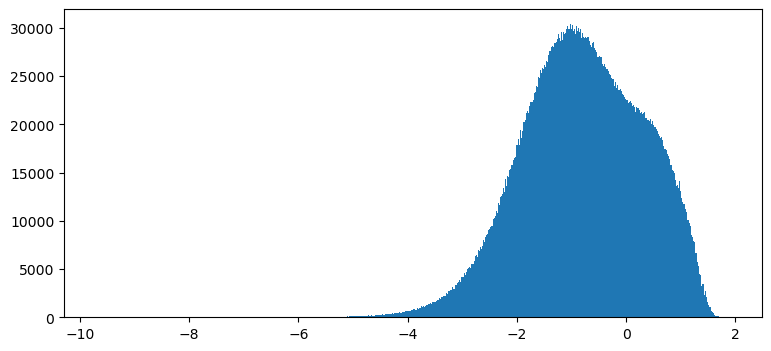

In [17]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

In [14]:
np.sum(ex<-6)

674

In [10]:
np.sum(ex<-4)/ex.shape[0]

0.004037345781927309

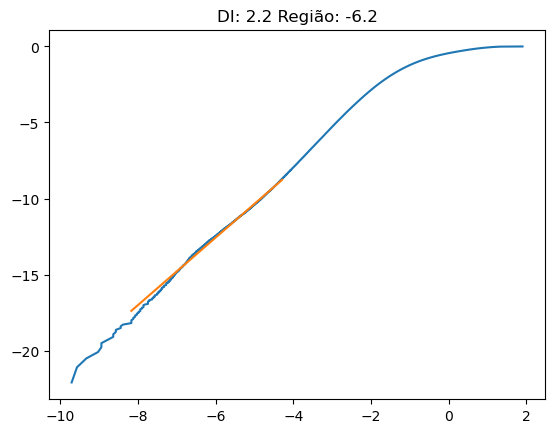

(2.2207575723659456, -6.224930925100251)

In [18]:
getDI2(ex, ey, printFLag=True, resaFlag=False)

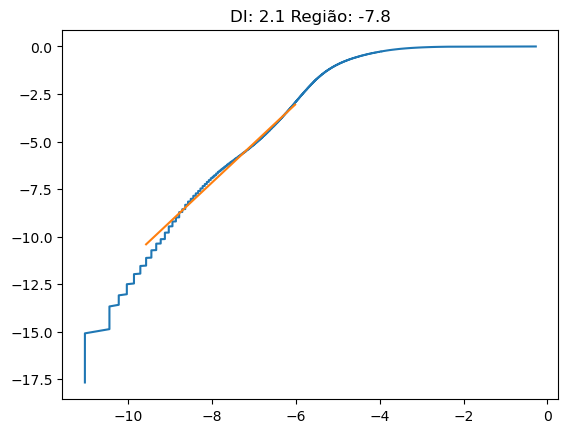

(2.06936121293861, -7.80320759473862)

In [56]:
getDI2(ex, ey, printFLag=True, resaFlag=False)

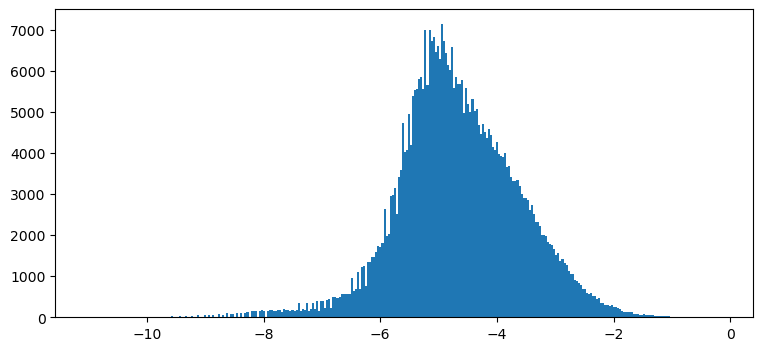

In [19]:
ex, ey = getCRNN(X, 20)
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

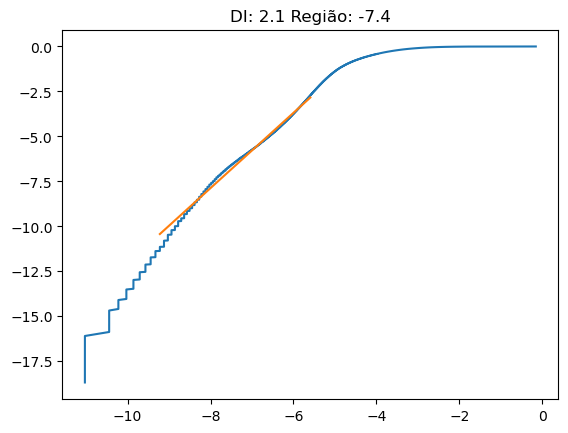

(2.0922540761848865, -7.404906167965027)

In [21]:
getDI2(ex, ey, printFLag=True, resaFlag=False)

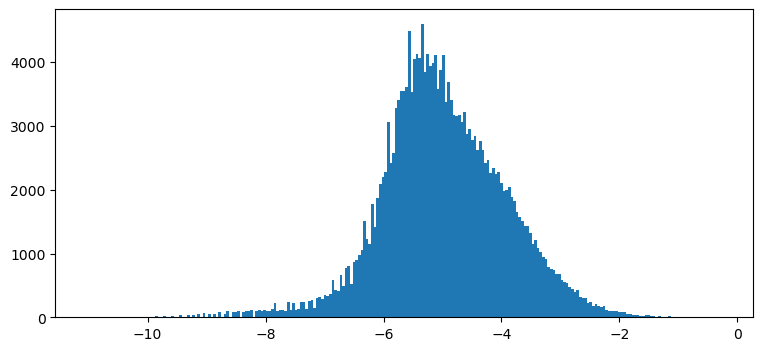

In [53]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

# Incluir janela temporal

In [24]:
nu = 0
Na = 21000
Ne = 3000
nd = 0
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(3):
    aux.append(picotar(X[:,i], 30, 1))
X = np.hstack(aux)
X.shape

(20971, 90)

In [19]:
ex, ey = getCRNN(X, 10)

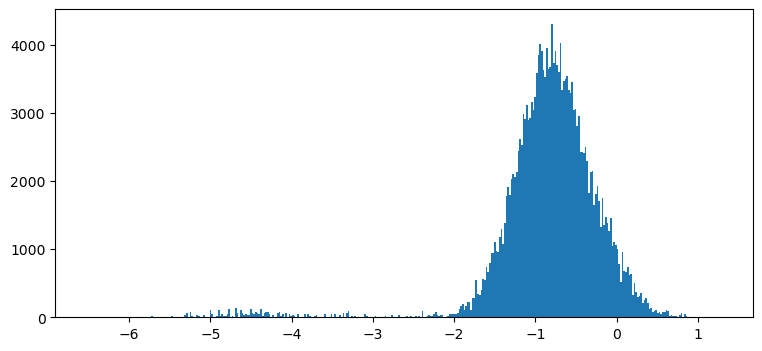

In [20]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

In [25]:
ex.shape

(209710,)

3.7457167986822233

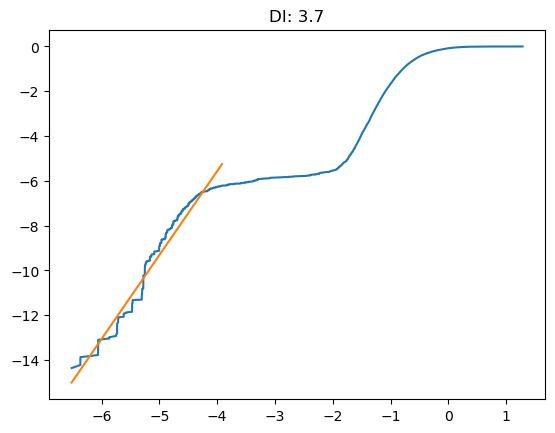

In [23]:
getDI(ex, ey, printFLag=True, resaFlag=True)

In [ ]:
nu = 0
J = 20
k = 5
DIest = np.zeros((7,7))
pos = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :3]/10
        aux = []
        for i in range(X.shape[1]):
            aux.append(picotar(X[:,i], J, 1))
        X = np.hstack(aux)
        ex, ey = getCRNN(X, k)
        DIest[na,nd], pos[na,nd] = getDI2(ex,ey)

In [36]:
fig = px.imshow(DIest, width=800, title='Acc do usuário '+users[nu],
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

## Analisando resultado

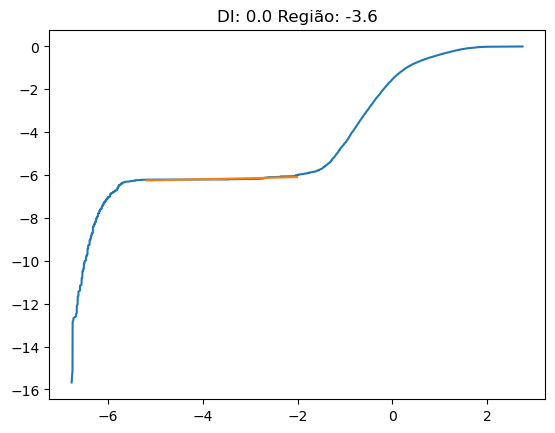

In [40]:
nu = 0
J = 20
k = 5
nd = 3
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

In [50]:
i = 0
k = 140
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_

Text(0.5, 1.0, 'DI: 8.6')

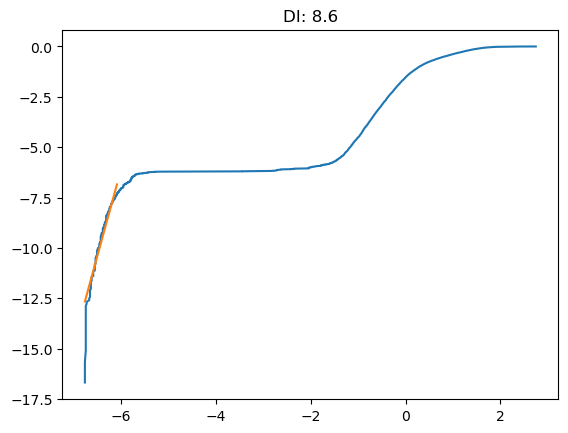

In [51]:
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

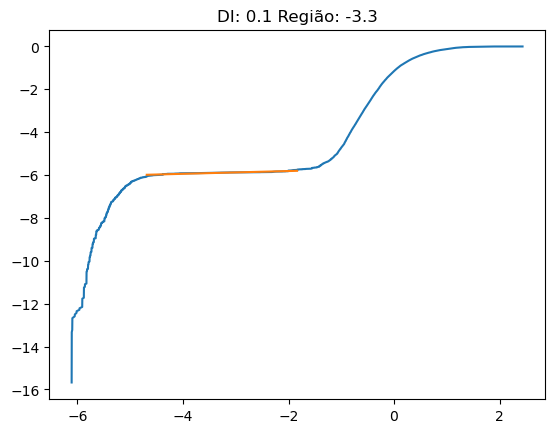

In [52]:
nu = 0
J = 20
k = 5
nd = 4
na = 0
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

Text(0.5, 1.0, 'DI: 9.9')

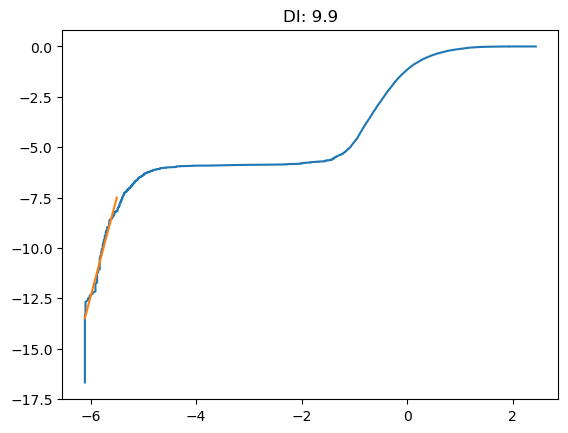

In [53]:
i = 0
k = 140
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

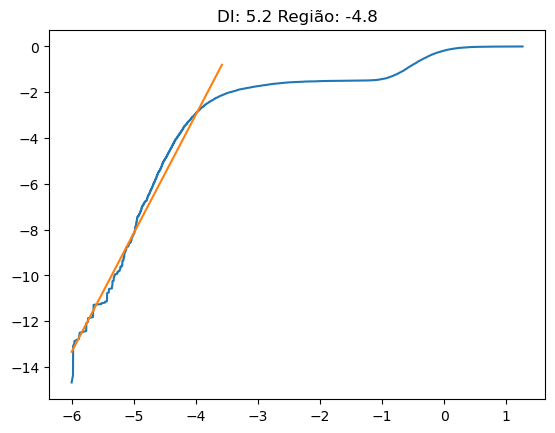

In [54]:
nu = 0
J = 20
k = 5
nd = 0
na = 3
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

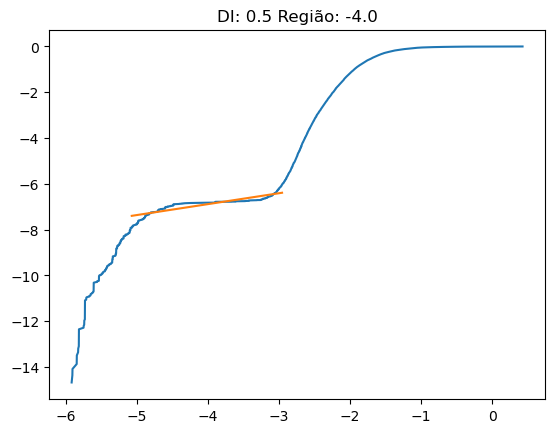

In [55]:
nu = 0
J = 20
k = 5
nd = 0
na = 6
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

Text(0.5, 1.0, 'DI: 10.3')

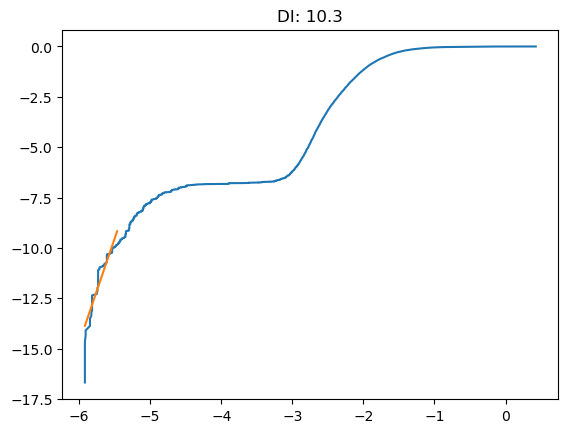

In [56]:
i = 0
k = 140
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

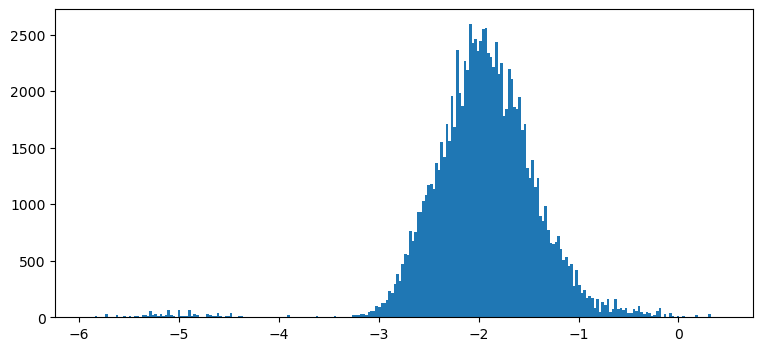

In [57]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

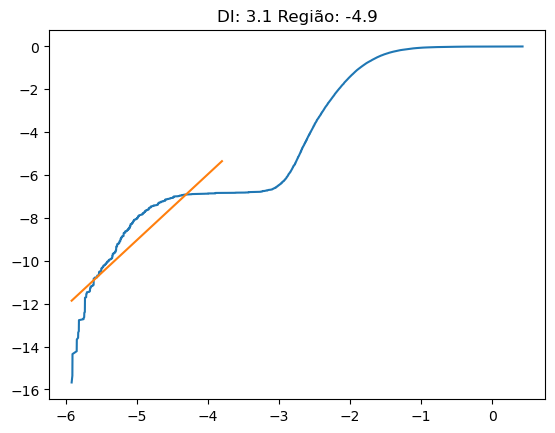

In [58]:
nu = 0
J = 20
k = 10
nd = 0
na = 6
X = np.array(Udata[nu][nd])[na, :, :3]/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)
DIest[na,nd], pos[na,nd] = getDI2(ex,ey, printFLag=True, resaFlag=True)

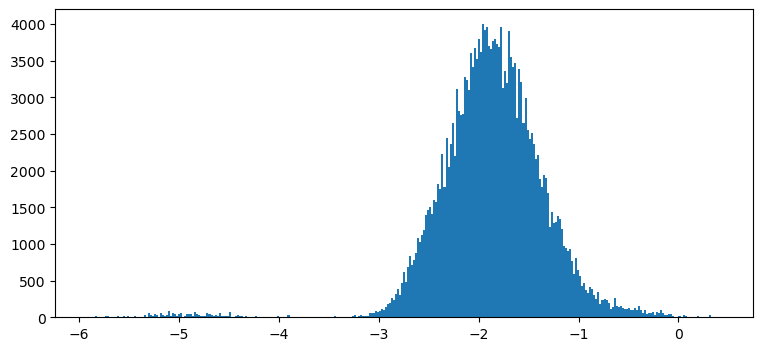

In [59]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

Text(0.5, 1.0, 'DI: 6.1')

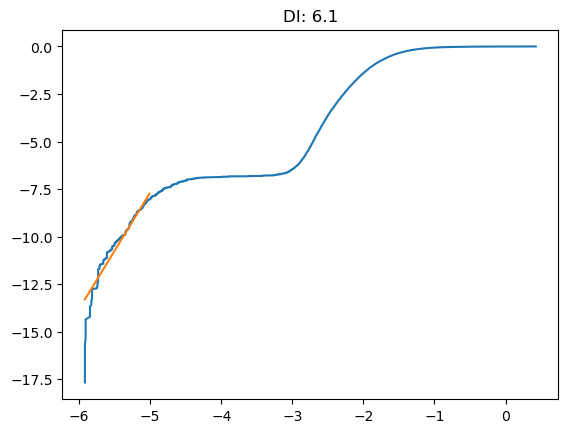

In [64]:
i = 0
k = 70
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

## Acc+gyr

In [ ]:
Na = 21000*7
k = 5
DIest = np.zeros((10,7))
for nd in tqdm(range(len(posis))):
    for nu in range(10):
        X = np.array(Udata[nu][nd])[:, :, :3].reshape(Na,3)/10
        aux = []
        for i in range(X.shape[1]):
            aux.append(picotar(X[:,i], J, 1))
        X = np.hstack(aux)
        ex, ey = getCRNN(X, k)
        DIest[nu,nd], aux = getDI2(ex,ey)
DIest.round(1)

  0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
Na = 21000*7
J = 20
k = 5
nd = 0
nu = 0
X = np.array(Udata[nu][nd])[:, :, :3].reshape(Na,3)/10
aux = []
for i in range(X.shape[1]):
    aux.append(picotar(X[:,i], J, 1))
X = np.hstack(aux)
ex, ey = getCRNN(X, k)

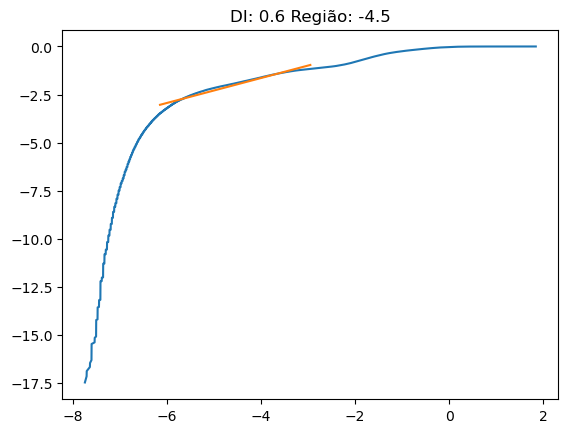

(0.6487673918808224, -4.5473753647306285)

In [12]:
getDI2(ex,ey, printFLag=True, resaFlag=True)

Text(0.5, 1.0, 'DI: 9.6')

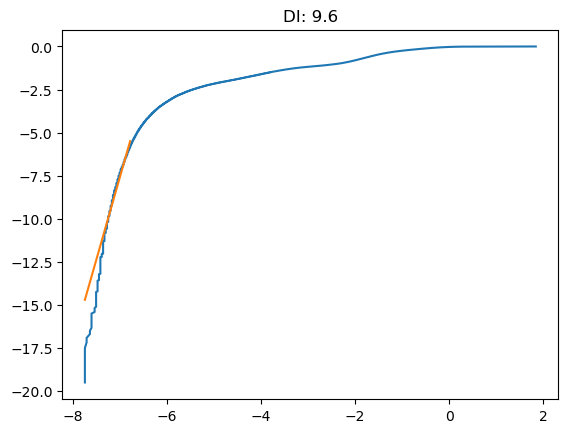

In [15]:
i = 0
k = 100
janela = 10
faixa = (max(ex)-min(ex))/k
limi = min(ex)+faixa*i
lims = min(ex)+faixa*(i+janela)
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
dim = regre.coef_[0]
b = regre.intercept_
plt.plot(ex,ey)
plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim+b)
plt.title('DI: '+str(dim.round(1)))

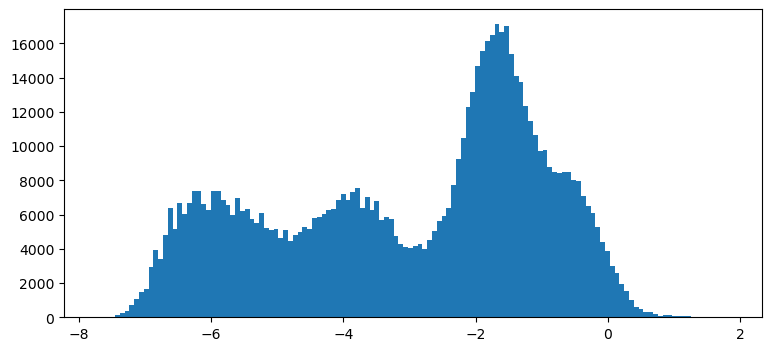

In [13]:
plt.figure(figsize=(9,4))
aux = plt.hist(ex, bins='auto')

In [ ]:
nu = 0
J = 20
k = 5
DIest = np.zeros((7,7))
pos = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :3]/10
        aux = []
        for i in range(X.shape[1]):
            aux.append(picotar(X[:,i], J, 1))
        X = np.hstack(aux)
        ex, ey = getCRNN(X, k)
        DIest[na,nd], pos[na,nd] = getDI2(ex,ey)

In [23]:
X = np.array(Udata[nu][nd])[na, :, :3]/10
px.scatter(X)